In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import warnings

In [22]:
### orginal data ###
df_train = pd.read_csv("./titanic/train.csv")

df_train.drop(columns=["PassengerId", "Cabin"], inplace=True)

df_train["Embarked"].fillna(df_train["Embarked"].unique()[0], inplace=True)
df_train['Name'] = df_train['Name'].str.split(', ').str[1].str.split('. ').str[0]

df_train['Master'] = (df_train['Name']=='Master')
df_train=df_train.drop(columns='Name')
df_train=df_train.drop(columns='Ticket')

# age_new 컬럼 생성.
df_train.loc[df_train.Age >= 50, "age_new"] = "old"
df_train.loc[(df_train.Age < 50) & (df_train.Age>=10), "age_new"] = "young"
df_train.loc[df_train.Age < 10, "age_new"] = "baby"

# 인코딩
og_columns = df_train.columns[(df_train.dtypes=='O')|(df_train.dtypes=='category')|(df_train.dtypes=='bool')]
for i in og_columns : 
    globals()[f'df_train_{i}_encoder'] = LabelEncoder()
    globals()[f'df_train_{i}_encoder'].fit(df_train[i])
    df_train[i] = globals()[f'df_train_{i}_encoder'].transform(df_train[i])
    
# 연령의 결측치 해결
Age_md = df_train.groupby(['Pclass', 'Sex']).Age.agg(['median'])
df_train.loc[(df_train['Sex'] ==  0) & (df_train['Pclass'] == 1) & (df_train.Age.isna()), "Age"] = Age_md.loc[1, 0][0]
df_train.loc[(df_train['Sex'] == 0) & (df_train['Pclass'] == 2) & (df_train.Age.isna()), "Age"] = Age_md.loc[2, 0][0]
df_train.loc[(df_train['Sex'] == 0) & (df_train['Pclass'] == 3) & (df_train.Age.isna()), "Age"] = Age_md.loc[3, 0][0]
df_train.loc[(df_train['Sex'] == 1) & (df_train['Pclass'] == 1) & (df_train.Age.isna()), "Age"] = Age_md.loc[1, 1][0]
df_train.loc[(df_train['Sex'] == 1) & (df_train['Pclass'] == 2) & (df_train.Age.isna()), "Age"] = Age_md.loc[2, 1][0]
df_train.loc[(df_train['Sex'] == 1) & (df_train['Pclass'] == 3) & (df_train.Age.isna()), "Age"] = Age_md.loc[3, 1][0]

df_train["family"] = df_train.SibSp + df_train.Parch
df_train.drop(columns=["SibSp", "Parch"], inplace=True)

# X, Y , test, train 분리
X = df_train.drop(columns='Fare')
y = df_train['Fare']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)


# 새로운 타이타닉 데이터 전처리 
df_test = pd.read_csv('./test.csv')

df_test.drop(columns=["PassengerId", "Cabin"], inplace=True)
df_test['Name'] = df_test['Name'].str.split(', ').str[1].str.split('. ').str[0]

df_test['Master']=(df_test['Name']=='Master')
df_test=df_test.drop(columns='Name')
df_test=df_test.drop(columns='Ticket')

# 연령의 결측치 해결
# fare 결측치 해결
age_md = df_test.groupby(['Pclass', 'Sex']).Age.agg(['mean'])
df_test.loc[(df_test['Sex'] == 'male') & (df_test['Pclass'] == 1) & (df_test.Age.isna()), 'Age'] = age_md.loc[1, 'male'][0]
df_test.loc[(df_test['Sex'] == 'male') & (df_test['Pclass'] == 2) & (df_test.Age.isna()), 'Age'] = age_md.loc[2, 'male'][0]
df_test.loc[(df_test['Sex'] == 'male') & (df_test['Pclass'] == 3) & (df_test.Age.isna()), 'Age'] = age_md.loc[3, 'male'][0]
df_test.loc[(df_test['Sex'] == 'female') & (df_test['Pclass'] == 1) & (df_test.Age.isna()), 'Age'] = age_md.loc[1, 'female'][0]
df_test.loc[(df_test['Sex'] == 'female') & (df_test['Pclass'] == 2) & (df_test.Age.isna()), 'Age'] = age_md.loc[2, 'female'][0]
df_test.loc[(df_test['Sex'] == 'female') & (df_test['Pclass'] == 3) & (df_test.Age.isna()), 'Age'] = age_md.loc[3, 'female'][0]
df_test.Fare.fillna(df_test["Fare"].mean(), inplace=True)

# age_new 생성
df_test.loc[df_test.Age >= 50, "age_new"] = "old"
df_test.loc[(df_test.Age < 50) & (df_test.Age>=10), "age_new"] = "young"
df_test.loc[df_test.Age < 10, "age_new"] = "baby"

df_test["family"] = df_test.SibSp + df_test.Parch
df_test.drop(columns=["SibSp", "Parch"], inplace=True)

og_columns = df_test.columns[(df_test.dtypes=='O')|(df_test.dtypes=='category')|(df_test.dtypes=='bool')]
for i in og_columns : 
    globals()[f'df_test{i}_encoder'] = LabelEncoder()
    globals()[f'df_test{i}_encoder'].fit(df_test[i])
    df_test[i] = globals()[f'df_test{i}_encoder'].transform(df_test[i])

In [122]:
# 각 컬럼별 데이터 표준화

from sklearn.preprocessing import StandardScaler

df_inputs = df_train.iloc[:, 1:]
df_scaled = StandardScaler().fit_transform(df_inputs)
tt_scale_DF = pd.DataFrame(df_scaled)
tt_scale_DF['Survived'] = df_train.Survived
tt_scale_DF.describe()

,0,1,2,3,4,5,6,7,Survived
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000
mean,-2.031048e-16,-4.059603e-16,1.804891e-16,-4.373606e-17,1.556306e-16,-2.293339e-16,-2.524792e-17,2.566846e-16,0.383838
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,0.486592
min,-1.566107e+00,-1.355574e+00,-2.157819e+00,-6.484217e-01,-1.942303e+00,-2.168030e-01,-2.642322e+00,-5.609748e-01,0.000000
25%,-3.693648e-01,-1.355574e+00,-5.724938e-01,-4.891482e-01,-6.781745e-01,-2.168030e-01,3.150980e-02,-5.609748e-01,0.000000
50%,8.273772e-01,7.376951e-01,-2.340704e-01,-3.573909e-01,5.859541e-01,-2.168030e-01,3.150980e-02,-5.609748e-01,0.000000
75%,8.273772e-01,7.376951e-01,5.179814e-01,-2.424635e-02,5.859541e-01,-2.168030e-01,3.150980e-02,5.915988e-02,1.000000
max,8.273772e-01,7.376951e-01,3.827009e+00,9.667167e+00,5.859541e-01,4.612483e+00,1.368426e+00,5.640372e+00,1.000000


In [142]:
from sklearn.decomposition import PCA

# 타이타닉 X데이터를 2차원으로 축소
# n_components 몇개의 Feature로 데이터 차원 줄일것인가
pca = PCA(n_components=2)
# 표준화 데이터를 학습
X2D = pca.fit_transform(X)

result = pd.DataFrame(X2D)
result.index = list(range(1, 892))
result.columns = ['z1', 'z2']
result['y'] = y
result.plot(kind='scatter', x='z1', y='z2', figsize=(10, 5),
        cmap='viridis', c=y, s=50, alpha=0.3)

# 설명된 분산의 비율
# 적절한 차원 수 선택하기
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
pca = PCA(n_components=d)
XTD = pca.fit_transform(X)

# 실제로는 분산의 비율로 설정하는 것이 좋음

ValueError: Length mismatch: Expected axis has 50 elements, new values have 891 elements

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 100, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.xlim(-1,15)
#plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
#             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

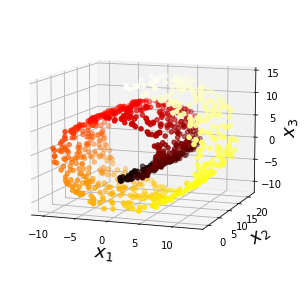

In [15]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
# save_fig("swiss_roll_plot")
plt.show()

In [26]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [30]:
pd.DataFrame(X_reduced)

,0,1
0,-13.039956,-27.342388
1,-24.500731,2.695840
2,-17.491931,-3.130713
3,-21.296571,-25.966139
4,-5.650512,11.557178
...,...,...
796,-25.646403,-6.256686
797,-25.520247,-2.757640
798,-21.500801,-9.886686
799,-17.177845,-8.140788


In [31]:
pd.DataFrame(X_recovered)

,0,1,2,3,4,5,6,7
0,3.036788,0.526573,0.944304,20.584893,1.583343,0.211779,1.813057,1.863175
1,2.469543,0.692254,30.513912,8.038390,1.609221,0.030029,2.018389,0.661953
2,2.536330,0.652077,24.953055,15.254254,1.587624,0.065253,1.972969,0.927136
3,3.080659,0.547152,2.016692,12.284246,1.611310,0.203500,1.831499,1.756150
4,2.101331,0.703783,40.048991,26.551892,1.539848,-0.023728,2.052986,0.457077
...,...,...,...,...,...,...,...,...
796,2.679819,0.650538,21.534449,7.219676,1.617309,0.084226,1.962523,0.989290
797,2.600540,0.667383,25.032277,7.218280,1.615262,0.063046,1.984734,0.859190
798,2.723424,0.625878,18.061910,11.494444,1.604619,0.106172,1.934483,1.153016
799,2.645375,0.627127,19.962795,15.750609,1.588841,0.095577,1.940588,1.116746


In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
lda_pred = lda.predict(df_test)
df_test['survived'] = lda_pred

# 파일 저장
tit = pd.read_csv('./test.csv')
tit.drop(list(tit.columns)[1:], axis = 1, inplace=True)
tit['Survived'] = df_test['survived']
tit.set_index('PassengerId', inplace=True)
tit.to_csv('tit_test_lda.csv')

In [73]:
"""
1. 타이타닉 survived 제외
2. X값으로 군집화 Kmeans
3. 최적의 군집 개수. 실루엣 스코어
4. 임의의 2개의 군집을 Survived에 비교
"""

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8,
                init='k-means++',
                n_init=10,
                max_iter=300,
                tol=0.0001,
                verbose=0,
                random_state=None,
                algorithm='lloyd',)

kmeans_labels= kmeans.fit_predict(X)
silhouette_avg = silhouette_score(X, kmeans_labels)

# silhouestte socre가 높을 수 록 좋은 군집의수
# from sklearn.metrics import silhouette_score
# silhouette_score(X, kmeans.fit(X_train))

In [69]:
silhouette_avg

0.473119448605943

In [70]:
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,15)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

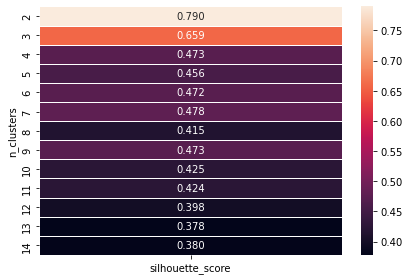

In [71]:
visualize_silhouette_layer(X)

[(2, 0.7897454419911212), (3, 0.6585696327719451), (7, 0.47846108412556654), (9, 0.4727554830479799), (4, 0.47265799074905335), (6, 0.4719614051959549), (5, 0.4559905396547574), (10, 0.42453153400100047), (11, 0.4238783826516895), (8, 0.41490657793374464), (12, 0.398408624425026), (14, 0.3804080323496965), (13, 0.37796821776666256)]


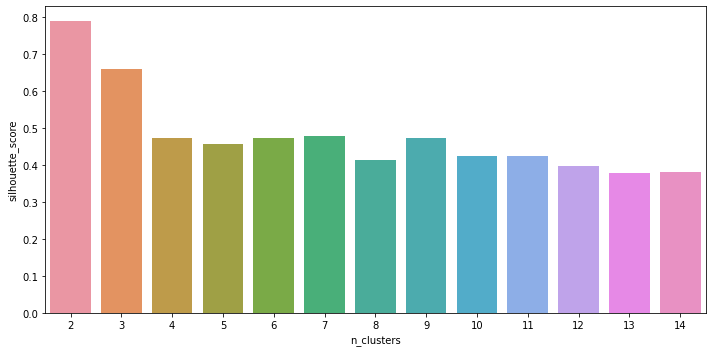

In [120]:
def visualize_silhouette_layer2(data, param_init='random', param_n_init=10, param_max_iter=300, param_tol=0.0002):
    clusters_range = range(2,15)
    results = []
    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0, tol=param_tol)
        cluster_labels = clusterer.fit_predict(data)
        silhouette = silhouette_score(data, cluster_labels)
        results.append((i, silhouette))
    results.sort(key= lambda x: x[1], reverse=True)
    print(results)
    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    plt.figure(figsize=(10,5))
    sns.barplot(x=result.n_clusters, y=result.silhouette_score)
    plt.tight_layout()
    plt.show()
    
visualize_silhouette_layer2(X, param_init='random', param_n_init=10, param_max_iter=300)

In [102]:
kmeans = KMeans(n_clusters=2,
                init='k-means++',
                n_init=10,
                max_iter=300,
                tol=0.0001,
                verbose=0,
                random_state=None,
                algorithm='lloyd',)

kmeans_labels= kmeans.fit(X, y)
kmeans_labels_pred = kmeans_labels.predict(df_test)
# df_test['survived'] = kmeans_labels_pred




In [103]:
print(metrics.classification_report(y_test, kmeans_labels.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.98      0.81        59
           1       0.80      0.13      0.22        31

    accuracy                           0.69        90
   macro avg       0.74      0.56      0.51        90
weighted avg       0.72      0.69      0.60        90



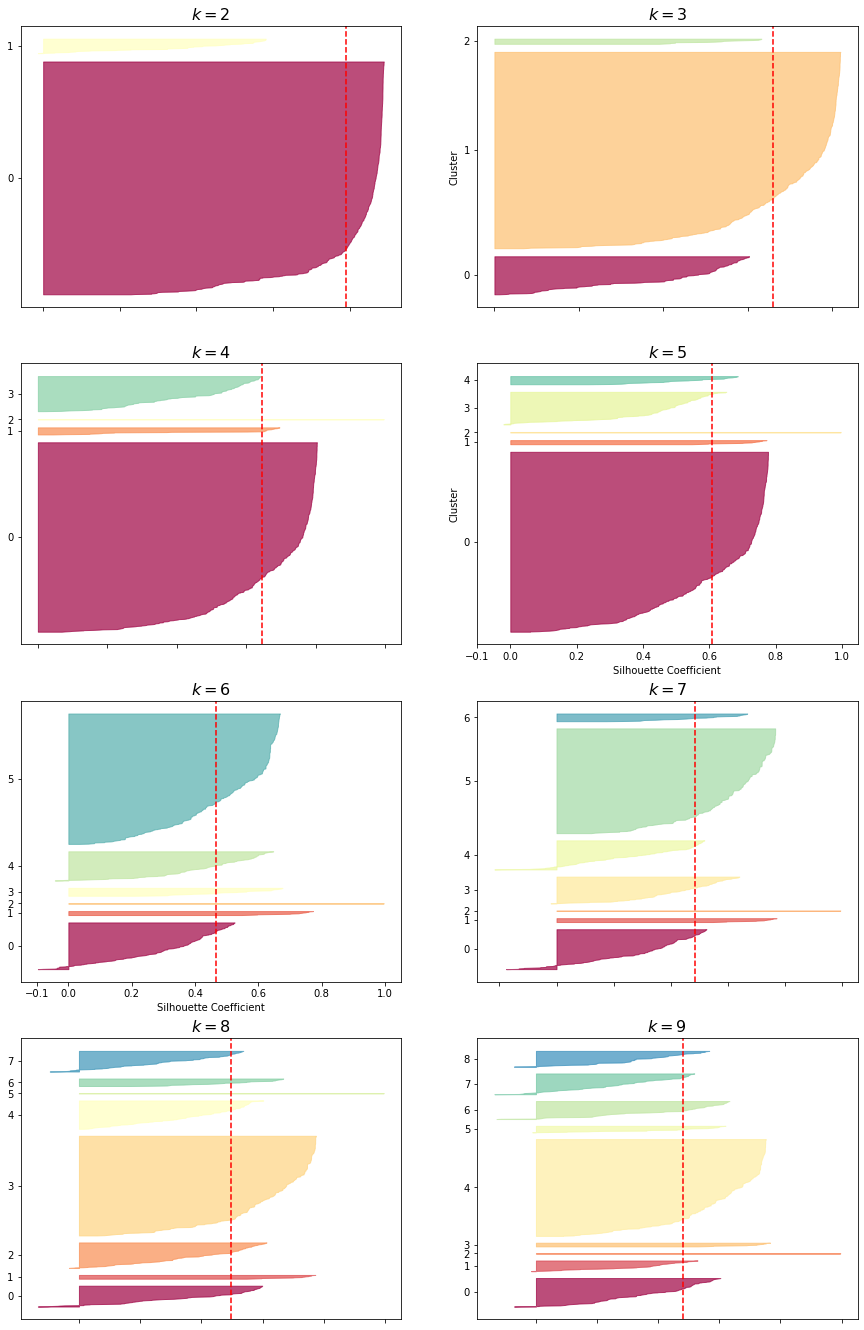

In [128]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
kmeans_per_k = [KMeans(n_clusters=k, random_state=19).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]
plt.figure(figsize=(15, 30))
for k in range(2, 10):
    plt.subplot(5, 2, k-1)
    y_pred = kmeans_per_k[k-1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)
    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
#save_fig("silhouette_analysis_plot")
plt.show()

In [212]:
"""
군집의 또 다른 사용처는 레이블이 없는 샘플이 많다.
레이블이 있는 샘플이 적을 때 사용하는 준지도 학습.
타이타닉 학습 데이터의 개수를 50개로 제한.
나머지 학습 데이터의 레이블 삭제.
전체 학습 데이터 세트를 kmeans로 50개 군집화 진행
각 센트로이드에서 가장 가까운
"""

# 타이타닉 50개의 데이터만 추출하여 학습 후 캐글 데이터로 score 확인.
df_train_cut = pd.read_csv("./titanic/train.csv")[:50]

df_train_cut.drop(columns=["PassengerId", "Cabin"], inplace=True)

df_train_cut["Embarked"].fillna(df_train_cut["Embarked"].unique()[0], inplace=True)
df_train_cut['Name'] = df_train_cut['Name'].str.split(', ').str[1].str.split('. ').str[0]

df_train_cut['Master'] = (df_train_cut['Name']=='Master')
df_train_cut=df_train_cut.drop(columns='Name')
df_train_cut=df_train_cut.drop(columns='Ticket')

# age_new 컬럼 생성.
df_train_cut.loc[df_train_cut.Age >= 50, "age_new"] = "old"
df_train_cut.loc[(df_train_cut.Age < 50) & (df_train_cut.Age>=10), "age_new"] = "young"
df_train_cut.loc[df_train_cut.Age < 10, "age_new"] = "baby"

# 인코딩
og_columns = df_train_cut.columns[(df_train_cut.dtypes=='O')|(df_train_cut.dtypes=='category')|(df_train_cut.dtypes=='bool')]
for i in og_columns : 
    globals()[f'df_train_cut_{i}_encoder'] = LabelEncoder()
    globals()[f'df_train_cut_{i}_encoder'].fit(df_train_cut[i])
    df_train_cut[i] = globals()[f'df_train_cut_{i}_encoder'].transform(df_train_cut[i])
    
# 연령의 결측치 해결
Age_md = df_train_cut.groupby(['Pclass', 'Sex']).Age.agg(['median'])
df_train_cut.loc[(df_train_cut['Sex'] ==  0) & (df_train_cut['Pclass'] == 1) & (df_train_cut.Age.isna()), "Age"] = Age_md.loc[1, 0][0]
df_train_cut.loc[(df_train_cut['Sex'] == 0) & (df_train_cut['Pclass'] == 2) & (df_train_cut.Age.isna()), "Age"] = Age_md.loc[2, 0][0]
df_train_cut.loc[(df_train_cut['Sex'] == 0) & (df_train_cut['Pclass'] == 3) & (df_train_cut.Age.isna()), "Age"] = Age_md.loc[3, 0][0]
df_train_cut.loc[(df_train_cut['Sex'] == 1) & (df_train_cut['Pclass'] == 1) & (df_train_cut.Age.isna()), "Age"] = Age_md.loc[1, 1][0]
df_train_cut.loc[(df_train_cut['Sex'] == 1) & (df_train_cut['Pclass'] == 2) & (df_train_cut.Age.isna()), "Age"] = Age_md.loc[2, 1][0]
df_train_cut.loc[(df_train_cut['Sex'] == 1) & (df_train_cut['Pclass'] == 3) & (df_train_cut.Age.isna()), "Age"] = Age_md.loc[3, 1][0]

df_train_cut["family"] = df_train_cut.SibSp + df_train_cut.Parch
df_train_cut.drop(columns=["SibSp", "Parch"], inplace=True)

# X, Y , test, train 분리
X_50 = df_train_cut.drop(columns='Survived')
y_50 = df_train_cut['Survived']
from sklearn.model_selection import train_test_split
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X, y, test_size=0.1, random_state=19)

# 답안지
df_answer = pd.read_csv("./titanic/answer_tit.csv")
df_answer = df_answer.Survived

In [169]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 

lda = LinearDiscriminantAnalysis()
lda.fit(X_50, y_50)
lda_pred = lda.predict(df_test)
accuracy_score(df_answer, lda_pred)

0.7631578947368421

In [147]:
print(metrics.classification_report(y_test, kmeans_labels.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



/Users/werther/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/werther/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/werther/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [154]:
kmeans = KMeans(n_clusters=50,
                init='k-means++',
                n_init=10,
                max_iter=300,
                tol=0.0001,
                verbose=0,
                random_state=None,
                algorithm='lloyd',)

kmeans_labels= kmeans.fit(X, y)
lda_pred = kmeans_labels.predict(df_test)
accuracy_score(df_answer, lda_pred)



/var/folders/t4/vwr916y50fv3wcm0xlgfkyg00000gn/T/ipykernel_1496/1500885064.py:10: ConvergenceWarning: Number of distinct clusters (49) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  kmeans_labels= kmeans.fit(X, y)


0.01674641148325359

In [217]:
# 50개의 군집 형성, 각 군집의 센트로이드에서 가장 가까운 샘플 50개 확인 후 예측
cluster = 420
kmeans = KMeans(n_clusters=cluster)

X_semi = kmeans.fit_transform(X)
print("전체 데이터 개수:", len(X_semi))
representative_idx = np.argmin(X_semi, axis=0)
X_semit_trn = X.loc[representative_idx]
y_semit_trn = y.loc[representative_idx]

lda = LinearDiscriminantAnalysis()
lda.fit(X_semit_trn, y_semit_trn)
print(f"lda 대표군집{cluster}개 예측 결과 :",lda.score(X_test, y_test))

전체 데이터 개수: 891
lda 대표군집420개 예측 결과 : 0.8777777777777778


In [216]:
dtclf = DecisionTreeClassifier()
dtclf.fit(X_semit_trn, y_semit_trn)
print(f"dtclf 대표군집{cluster}개 예측 결과 :",lda.score(X_test, y_test))

dtclf 대표군집420개 예측 결과 : 0.8777777777777778


In [206]:
dtclf_pred = dtclf.predict(df_test)
df_test['survived'] = dtclf_pred

# 파일 저장
tit = pd.read_csv('./test.csv')
tit.drop(list(tit.columns)[1:], axis = 1, inplace=True)
tit['Survived'] = df_test['survived']
tit.set_index('PassengerId', inplace=True)
tit.to_csv('tit_test_dtclf_kmean.csv')

In [9]:
from sklearn.linear_model import LinearRegression

In [23]:
lr = LinearRegression()
lrfit = lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
mean_squared_error(y_test, lr_pred)


712.1069419495855

/Users/werther/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

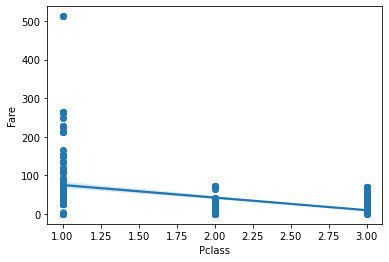

In [27]:
sns.regplot(df_train['Pclass'], df_train['Fare'], "o")

In [21]:
df_train

,Survived,Pclass,Sex,Age,Fare,Embarked,Master,age_new,family
0,0,3,1,22.0,7.2500,2,0,2,1
1,1,1,0,38.0,71.2833,0,0,2,1
2,1,3,0,26.0,7.9250,2,0,2,0
3,1,1,0,35.0,53.1000,2,0,2,1
4,0,3,1,35.0,8.0500,2,0,2,0
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,13.0000,2,0,2,0
887,1,1,0,19.0,30.0000,2,0,2,0
888,0,3,0,21.5,23.4500,2,0,3,3
889,1,1,1,26.0,30.0000,0,0,2,0
